In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
import catboost as cb

pd.set_option('display.max_rows', 300)

In [2]:
train_b = pd.read_csv("raw/data_b_train.csv")
train_m = pd.read_csv("raw/data_m_train.csv")
valid_b = pd.read_csv("raw/data_b_test.csv")
valid_m = pd.read_csv("raw/data_m_test.csv")
train_y = pd.read_csv('raw/y_train.csv')


b_col = ['id', 'x_num_0', 'x_num_1', 'x_num_2', 'x_num_3', 'x_cat_0',
         'x_cat_3', 'x_cat_4', 'x_cat_9', 'x_cat_10', 'x_cat_11']


train_b = train_b[b_col]
valid_b = valid_b[b_col]


m_col = ['id','timestamp','x_num_70', 'x_num_5', 'x_num_6', 'x_num_7', 'x_num_10',
         'x_num_13', 'x_num_14', 'x_num_15', 'x_num_17', 'x_num_18', 'x_num_20',
         'x_num_22', 'x_num_23', 'x_num_24', 'x_num_25', 'x_num_26', 'x_num_27',
         'x_num_28', 'x_num_30','x_num_32', 'x_num_33',
         'x_num_39', 'x_num_41', 'x_num_43', 'x_num_45', 'x_num_46',
         'x_num_47', 'x_num_49', 'x_num_50', 'x_num_51', 'x_num_55', 
         'x_num_63', 'x_num_68', 'x_num_69']


train_m = train_m[m_col]
valid_m = valid_m[m_col]

In [3]:
valid_m.replace(-99, np.nan, inplace=True)
valid_b.replace(-99, 0,inplace=True)

In [4]:
def change_name(df,suffix):
    names = df.columns.tolist()
    if 'id' in names:
        names.remove('id')
    
    names = [col + suffix for col in names]
    names = ['id'] + names
    df.columns = names
    return df

In [5]:
more_cols = ['x_num_70', 'x_num_5', 'x_num_6', 'x_num_7', 'x_num_10',
         'x_num_13', 'x_num_14', 'x_num_15', 'x_num_17', 'x_num_18', 'x_num_20',
         'x_num_22', 'x_num_23', 'x_num_24', 'x_num_25', 'x_num_26', 'x_num_27',
         'x_num_28', 'x_num_30','x_num_32', 'x_num_33',
         'x_num_39', 'x_num_41', 'x_num_43', 'x_num_45', 'x_num_46',
         'x_num_47', 'x_num_49', 'x_num_50', 'x_num_51', 'x_num_55', 
         'x_num_63', 'x_num_68', 'x_num_69']

In [6]:
def pipeline(train,valid,more_cols):
    #最后一天
    train_last = train.sort_values('timestamp', ascending=False).groupby('id',as_index=False).first()
    valid_last = valid.sort_values('timestamp', ascending=False).groupby('id',as_index=False).first()
    
    train_last.drop(columns='timestamp',inplace=True)
    valid_last.drop(columns='timestamp',inplace=True)
    
    train = train[['id'] + more_cols]
    valid = valid[['id'] + more_cols]
    
    #max
    train_max = train.groupby('id',as_index=False).max()
    valid_max = valid.groupby('id',as_index=False).max()
        
    #mean
    train_mean = train.groupby('id',as_index=False).mean()
    valid_mean = valid.groupby('id',as_index=False).mean()
    
    #std
    train_std = train.groupby('id',as_index=False).std()
    valid_std = valid.groupby('id',as_index=False).std()
    train_std['id'] = train_mean['id']
    valid_std['id'] = valid_mean['id']
    
    #cov
    train_cov = train_std / train_mean
    valid_cov = valid_std / valid_mean
    train_cov['id'] = train_mean['id']
    valid_cov['id'] = valid_mean['id']
    
    #median 0.3454
    train_median = train.groupby('id',as_index=False).median()
    valid_median = valid.groupby('id',as_index=False).median()
    
    #0.3456
    train_mean_div_last = train_mean / train_last
    valid_mean_div_last = valid_mean / valid_last
    train_mean_div_last['id'] = train_mean['id']
    valid_mean_div_last['id'] = valid_mean['id']
    
    #0.352
    train_max_add_last = train_max + train_last
    valid_max_add_last = valid_max + valid_last
    train_max_add_last['id'] = train_mean['id']
    valid_max_add_last['id'] = valid_mean['id']
    
    
    train_last = change_name(train_last,'_last')
    valid_last = change_name(valid_last,'_last')
    
    train_max = change_name(train_max,'_max')
    valid_max = change_name(valid_max,'_max')
    
    train_mean = change_name(train_mean, '_mean')
    valid_mean = change_name(valid_mean, '_mean')
    
    train_cov = change_name(train_cov, '_cov')
    valid_cov = change_name(valid_cov, '_cov')
    
    train_std = change_name(train_std, '_std')
    valid_std = change_name(valid_std, '_std')
    
    train_median = change_name(train_median, '_median')
    valid_median = change_name(valid_median, '_median')
    
    train_max_add_last = change_name(train_max_add_last, '_max+last')
    valid_max_add_last = change_name(valid_max_add_last, '_max+last')

    train_mean_div_last = change_name(train_mean_div_last, '_mean/last')
    valid_mean_div_last = change_name(valid_mean_div_last, '_mean/last')
    
    
    train_info = pd.merge(train_last,train_cov,on='id')
    train_info = pd.merge(train_info,train_max,on='id')
    train_info = pd.merge(train_info,train_std,on='id')
    train_info = pd.merge(train_info,train_median,on='id')
    
    train_info = pd.merge(train_info,train_mean_div_last,on='id')
    train_info = pd.merge(train_info,train_max_add_last,on='id')

    valid_info = pd.merge(valid_last,valid_cov,on='id')
    valid_info = pd.merge(valid_info,valid_max,on='id')
    valid_info = pd.merge(valid_info,valid_std,on='id')
    valid_info = pd.merge(valid_info,valid_median,on='id')
    
    valid_info = pd.merge(valid_info,valid_mean_div_last,on='id')
    valid_info = pd.merge(valid_info,valid_max_add_last,on='id')

    return train_info,valid_info

In [7]:
def pipeline2(train,valid,cat_cols,last_cols):
    
    train_result = pd.DataFrame()
    train_result['id'] = train['id']
    valid_result = pd.DataFrame()
    valid_result['id'] = valid['id']
    
    #x_cat_0
    cat_col = cat_cols[0]
    train_df = train[[cat_col] + last_cols]
    valid_df = valid[[cat_col] + last_cols]
    
    #0.37 465 x_cat_0
    for col in last_cols:
        temp = train_df.groupby(cat_col)[col].transform(np.median)
        train_result[col + '_' + cat_col + '_*median'] = train_df[col] * temp
        temp = valid_df.groupby(cat_col)[col].transform(np.median)
        valid_result[col + '_' + cat_col + '_*median'] = valid_df[col] * temp
    
    #0.374 467 x_cat_9
    cat_col = cat_cols[3]
    train_df = train[[cat_col] + last_cols]
    valid_df = valid[[cat_col] + last_cols]
    
    for col in last_cols:
        temp = train_df.groupby(cat_col)[col].transform(np.median)
        train_result[col + '_' + cat_col + '_-median'] = train_df[col] - temp
        temp = valid_df.groupby(cat_col)[col].transform(np.median)
        valid_result[col + '_' + cat_col + '_-median'] = valid_df[col] - temp
    
    
    return train_result,valid_result

In [8]:
def pipeline3(train,valid,cat_cols):
    train_result = pd.DataFrame()
    train_result['id'] = train['id']
    valid_result = pd.DataFrame()
    valid_result['id'] = valid['id']
    
    #0.381 471 ['x_cat_0','x_cat_10','x_cat_11']
    #0.374 475 ['x_cat_0','x_cat_3',x_cat_10','x_cat_11']
    #一定不能带x_cat_9, 会急剧下降
    for i in range(len(cat_cols)-1):
        for j in range(i+1,len(cat_cols)):
            train_result[cat_cols[i] + '^' + cat_cols[j]] = train[cat_cols[i]] ^ train[cat_cols[j]]
            valid_result[cat_cols[i] + '^' + cat_cols[j]] = valid[cat_cols[i]] ^ valid[cat_cols[j]]
    
    return train_result,valid_result

In [9]:
def pipeline4(train,valid):
    train_result = pd.DataFrame()
    train_result['id'] = train['id']
    valid_result = pd.DataFrame()
    valid_result['id'] = valid['id']
    
    #0.384 465 x_num_0 * x_cat_9
    train_result['x_num_0_*_x_cat_9'] = train['x_num_0'] * train['x_cat_9']
    valid_result['x_num_0_*_x_cat_9'] = valid['x_num_0'] * valid['x_cat_9'] 
    

    return train_result,valid_result

In [10]:
def pipeline5(train,valid):
    train_result = pd.DataFrame()
    train_result['id'] = train['id']
    valid_result = pd.DataFrame()
    valid_result['id'] = valid['id']
    
    #0.386 462 x_num_47_last * x_cat_0
    train_result['x_num_47_last_*_x_cat_0'] = train['x_num_47_last'] * train['x_cat_0']
    valid_result['x_num_47_last_*_x_cat_0'] = valid['x_num_47_last'] * valid['x_cat_0']
    
    return train_result,valid_result

In [11]:
def pipeline6(train,valid):
    train_result = pd.DataFrame()
    train_result['id'] = train['id']
    valid_result = pd.DataFrame()
    valid_result['id'] = valid['id']
    
    long_cols = ['x_num_13_last', 'x_num_20_last', 'x_num_28_last', 'x_num_30_last', 
                 'x_num_43_last', 'x_num_46_last', 'x_num_47_last']
    
    for col in long_cols:
        train_result[col + '_ratio'] = train[col] / train[long_cols].sum(axis=1)
        valid_result[col + '_ratio'] = valid[col] / valid[long_cols].sum(axis=1)
    
    return train_result,valid_result

In [12]:
def pipeline7(train,valid):
    train_result = pd.DataFrame()
    train_result['id'] = train['id']
    valid_result = pd.DataFrame()
    valid_result['id'] = valid['id']
    
    long_cols = ['x_num_13_last', 'x_num_20_last', 'x_num_28_last', 'x_num_30_last', 
                 'x_num_43_last', 'x_num_46_last', 'x_num_47_last']
    #0.394
    for col in long_cols:
        train_result[col + '_log'] = np.log(train[col]+1e-99)
        valid_result[col + '_log'] = np.log(valid[col]+1e-99)
    
    return train_result,valid_result

In [21]:
def train_valid(train_m,valid_m,train_b,valid_b,more_cols,train_y,threshold=0.25):
    
    #mean max median last * - 
    train_info,valid_info = pipeline(train_m,valid_m,more_cols)
    train = pd.merge(train_b,train_info,on='id')
    valid = pd.merge(valid_b,valid_info,on='id')
    
    #groupby cat * - 
    last_cols = [col + '_last' for col in more_cols]
    cat_cols = ['x_cat_0','x_cat_3','x_cat_4','x_cat_9','x_cat_10','x_cat_11']
    group_cols = ['id'] + cat_cols + last_cols
    train_group, valid_group = pipeline2(train[group_cols],valid[group_cols],cat_cols,last_cols)
    
    train = pd.merge(train,train_group,on='id')
    valid = pd.merge(valid,valid_group,on='id')
    
    #cat ^ 就这三个, 多加貌似都不行
    cat_cols = ['x_cat_0','x_cat_10','x_cat_11']
    group_cols = ['id'] + cat_cols
    train_cat,valid_cat = pipeline3(train[group_cols],valid[group_cols],cat_cols)
    train = pd.merge(train,train_cat,on='id')
    valid = pd.merge(valid,valid_cat,on='id')
    
    #x_num_0 * x_cat_9
    train_b_feature,valid_b_feature = pipeline4(train_b,valid_b)
    train = pd.merge(train,train_b_feature,on='id')
    valid = pd.merge(valid,valid_b_feature,on='id')

    #x_num_47_last * x_cat_0
    train_m_feature,valid_m_feature = pipeline5(train,valid)
    train = pd.merge(train,train_m_feature,on='id')
    valid = pd.merge(valid,valid_m_feature,on='id')
    
    # num / sum 求ratio
    train_6,valid_6 = pipeline6(train,valid)
    train = pd.merge(train,train_6,on='id')
    valid = pd.merge(valid,valid_6,on='id')
    
    # np.log
    train_7,valid_7 = pipeline7(train,valid)
    train = pd.merge(train,train_7,on='id')
    valid = pd.merge(valid,valid_7,on='id')
    
    
    train_y = train_y['target']
    train.drop(columns='id',inplace=True)
    valid.drop(columns='id',inplace=True)
    
    train_data = lgb.Dataset(train, label=train_y)

    params = {'boosting':'gbdt',
              'objective':'binary',
              'max_depth':7,
              'learning_rate':0.01,
              'num_leaves':50,
              'metric': ['binary_logloss', 'auc'],
              'verbose': -1
             }


    my_model = lgb.train(params, train_data,750)



    prediction = my_model.predict(train)
    
#     prediction = np.where(prediction < threshold, 0, 1)

    result = pd.DataFrame()
    result['id'] = train.index
    result['target'] = prediction
    return result,train,my_model,valid.index

In [22]:
result,train,model,result_index = train_valid(train_m,valid_m,train_b,valid_b,more_cols,train_y,threshold=0.25)

In [136]:
# 在训练集和预测集上的0，1分布
def zero_one_density(data):
    
    import seaborn as sns
    LABEL_SIZE = 18
    TITLE_SIZE = 20
    f, ax = plt.subplots(figsize=(15, 8))
    plate = sns.color_palette('deep')

    sns.kdeplot((data[data['origin']==0])['pred_cut'],color=plate[0])
    sns.kdeplot((data[data['origin']==1])['pred_cut'].dropna(), color=plate[1])
    
    plt.xticks(rotation='0',fontsize=LABEL_SIZE)
    plt.yticks(rotation='0',fontsize=LABEL_SIZE)
    plt.xlabel('Prediction probability', fontsize=LABEL_SIZE)
    
    plt.xlim(-0.1,1.1)
    plt.ylabel('Density', fontsize=LABEL_SIZE)
    plt.title('The Density of true value in prediction probability interval in train set', fontsize=TITLE_SIZE)
    plt.legend(('0', '1'),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0, fontsize=LABEL_SIZE)
    plt.savefig("训练集真实值区间概率分布密度图", dpi=720, bbox_inches='tight')

In [137]:
density = pd.DataFrame()

In [138]:
density['origin'] = train_y['target']
density['pred'] = result['target']

In [139]:
# density['origin_one'] = (density[density['origin']==1])['origin']
# density['origin_zero'] = (density[density['origin']==0])['origin']

# density['pred_one'] = (density[density['pred']==1])['pred']
# density['pred_zero'] = (density[density['pred']==0])['pred']

In [140]:
density['pred_cut'] = pd.cut(density['pred'], np.arange(0,1.05,0.05),labels=np.arange(0.025,1.025, 0.05))

In [141]:
density.head()

,origin,pred,pred_cut
0,0,0.077413,0.075
1,0,0.000423,0.025
2,1,0.737626,0.725
3,0,0.001013,0.025
4,1,0.742429,0.725


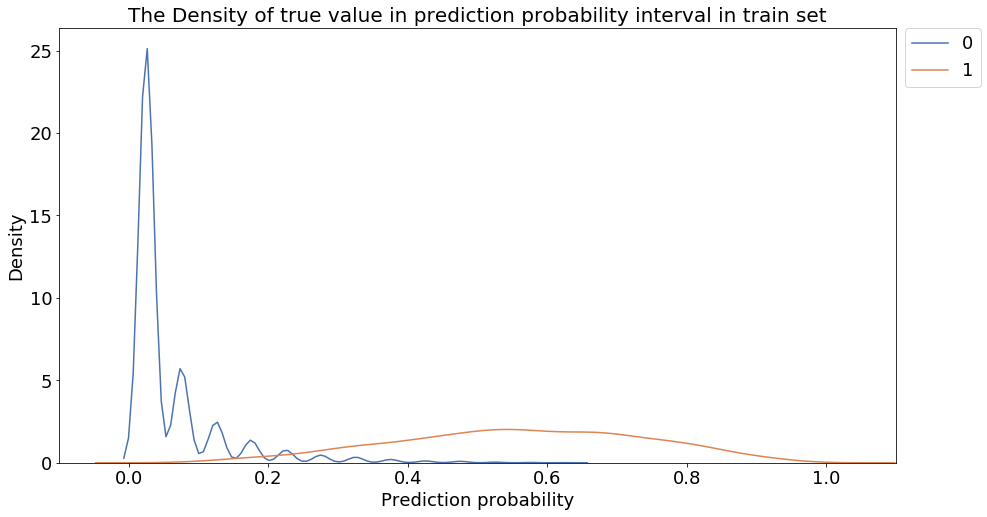

In [142]:
zero_one_density(density.drop('pred', axis=1))

In [ ]:
#397
result['target'].value_counts()

In [20]:
result.to_csv('test_900.csv',index=0)

In [43]:
# 查看1的不同数量
compare = pd.DataFrame()
compare['id'] = result_index
compare['402'] = (pd.read_csv('402.csv'))['target'].tolist()
compare['397'] = (pd.read_csv('397.csv'))['target'].tolist()
compare['test_700'] = (pd.read_csv('test_700.csv'))['target'].tolist()
compare['test_900'] = (pd.read_csv('test_900.csv'))['target'].tolist()
compare['test'] = result['target']

In [45]:
print(len(compare[compare['test_900']!=compare['402']]))
print(len(compare[compare['test_900']!=compare['397']]))
# print(len(compare[compare['402']!=compare['397']]))

21
77


In [32]:
print(len(compare[compare['test_700']!=compare['402']]))
print(len(compare[compare['test_900']!=compare['402']]))

26
21


In [36]:
compare[(compare['id']==39)|(compare['id']==35)|(compare['id']==65)|(compare['id']==714)|(compare['id']==2839)]

,id,402,397,test_700,test_900,test
35,35,0,0,0,0,0
39,39,0,0,0,0,0
65,65,0,0,0,0,0
714,714,0,0,0,0,0
2839,2839,0,0,0,0,0


In [40]:
compare[(compare['test_900']!=compare['402'])&(compare['test_700']!=compare['402'])]

,id,402,397,test_700,test_900,test
233,233,1,1,0,0,0
1693,1693,0,1,1,1,1


In [42]:
compare[compare['test_900']!=compare['402']]

,id,402,397,test_700,test_900,test
233,233,1,1,0,0,0
605,605,1,1,1,0,0
810,810,1,1,1,0,0
1189,1189,0,0,0,1,1
1243,1243,1,0,1,0,0
1331,1331,0,0,0,1,1
1693,1693,0,1,1,1,1
1766,1766,0,0,0,1,1
1873,1873,1,1,1,0,0
2459,2459,0,0,0,1,1


In [ ]:
corr.

In [62]:
cols = ['x_num_70', 'x_num_5', 'x_num_6', 'x_num_7', 'x_num_10',
         'x_num_13', 'x_num_14', 'x_num_15', 'x_num_17', 'x_num_18', 'x_num_20',
         'x_num_22', 'x_num_23', 'x_num_24', 'x_num_25', 'x_num_26', 'x_num_27',
         'x_num_28', 'x_num_30','x_num_32', 'x_num_33',
         'x_num_39', 'x_num_41', 'x_num_43', 'x_num_45', 'x_num_46',
         'x_num_47', 'x_num_49', 'x_num_50', 'x_num_51', 'x_num_55', 
         'x_num_63', 'x_num_68', 'x_num_69']

cols = [col + '_last' for col in cols]

In [24]:
col_list = []
for col in cols:
    if train[col].nunique() > 5000:
        col_list.append(col)

In [26]:
print(col_list)

['x_num_13_last', 'x_num_14_last', 'x_num_18_last', 'x_num_20_last', 'x_num_28_last', 'x_num_30_last', 'x_num_43_last', 'x_num_46_last', 'x_num_47_last']


In [95]:
importance1 = pd.DataFrame(list(zip(model.feature_name(),model.feature_importance(importance_type='gain'))))
importance1 = importance1.sort_values(by=1)
importance1.columns = ['feature','gain']

importance2 = pd.DataFrame(list(zip(model.feature_name(),model.feature_importance(importance_type='split'))))
importance2 = importance2.sort_values(by=1)
importance2.columns = ['feature','split']

importance = pd.merge(importance1,importance2,on='feature')
# importance = importance.groupby('feature',as_index=False).apply(np.mean).add_suffix('_mean')

In [96]:
importance[importance['gain']==0]

,feature,gain,split
0,x_num_39_median,0.0,0
1,x_num_46_last_x_cat_0_*median,0.0,0
2,x_num_41_last_x_cat_0_*median,0.0,0
3,x_num_33_last_x_cat_0_*median,0.0,0
4,x_num_32_last_x_cat_0_*median,0.0,0
5,x_num_28_last_x_cat_0_*median,0.0,0
6,x_num_26_last_x_cat_0_*median,0.0,0
7,x_num_24_last_x_cat_0_*median,0.0,0
8,x_num_22_last_x_cat_0_*median,0.0,0
9,x_num_17_last_x_cat_0_*median,0.0,0


In [59]:
pair = result.copy()

In [32]:
result.to_csv('384.csv',index=0)